In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models

  Cloning https://github.com/rwightman/pytorch-image-models to /tmp/pip-req-build-wjtu73i5
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models /tmp/pip-req-build-wjtu73i5
  Resolved https://github.com/rwightman/pytorch-image-models to commit 67b0b3d7c7da3dbd76f30375b086ba4a0656811f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import os
import glob
import time
import copy
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image

import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score as bas

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data = pd.read_csv('/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/trainset/trainset_true.csv')
data['GENDER'].values[data['GENDER'].values == 'M'] = 1
data['GENDER'].values[data['GENDER'].values == 'F'] = 0
data['GENDER'].values[data['GENDER'].values == 'm'] = 1
data['GENDER'].values[data['GENDER'].values == 'f'] = 0
data['YOB'] = pd.DatetimeIndex(data['DOB']).year
data['MOB'] = pd.DatetimeIndex(data['DOB']).month
data['IMAGES'] = None

for i, row in tqdm(data.iterrows(), total=len(data)):
    image_paths = glob.glob(f'/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/trainset/{row["ID"]}/*.jpg')
    images = []
    for p in image_paths:
        image = PIL.Image.open(p)
        images.append(image)
    data.at[i, 'IMAGES'] = images

100%|██████████| 163/163 [00:10<00:00, 15.70it/s]


In [4]:
testdata = pd.read_csv('/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/testset/testset_data.csv')
testdata['GENDER'].values[testdata['GENDER'].values == 'M'] = 1
testdata['GENDER'].values[testdata['GENDER'].values == 'F'] = 0
testdata['GENDER'].values[testdata['GENDER'].values == 'm'] = 1
testdata['GENDER'].values[testdata['GENDER'].values == 'f'] = 0
testdata['YOB'] = pd.DatetimeIndex(testdata['DOB']).year
testdata['MOB'] = pd.DatetimeIndex(testdata['DOB']).month
testdata['IMAGES'] = None

test_ids = []

for i, row in tqdm(testdata.iterrows(), total=len(testdata)):
    
    image_paths = glob.glob(f'/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/testset/{row["ID"]}/*.jpg')
    test_ids.append(row["ID"])
    images = []    
    for p in image_paths:
        image = PIL.Image.open(p)
        images.append(image)
    testdata.at[i, 'IMAGES'] = images


100%|██████████| 42/42 [00:02<00:00, 18.64it/s]


# Split into train/val

As the number of patients is small (163), we use a 50/50 split for reliable evaluation.

In [5]:
traindata, validdata = train_test_split(data, test_size=0.5, random_state=42)

# Preprocessing

These values were computed over the training images.

In [6]:
MEAN = torch.tensor([0.8183, 0.6977, 0.7034])
STD = torch.tensor([0.1917, 0.2156, 0.0917])

The dataset returns the images for a patient, stacked in a tensor, and the label of the patient.

In [7]:
class MILDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform, num_images=None):
        super().__init__()
        
        if transform is None:
            transform = lambda x: x
        
        self.data = data
        self.transform = transform
        self.num_images = num_images # allows to use only the n first images
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        if self.num_images is not None:
            indices = torch.randperm(len(row['IMAGES']))[:self.num_images]
            images = [row['IMAGES'][i] for i in indices]
        else:
            images = [img for img in row['IMAGES']]
        images = [self.transform(img) for img in images]
        images = torch.stack(images, 0)
        return images, row['LABEL']

The collate function is used to make batches of patients. It stacks and shuffles the images of all the patients in the batch and return indices that will allow to re-arrange the features into separate patients.

In [8]:
def collate_fn(inputs):
    images, labels = zip(*inputs)
    indices_a = torch.cat([i*torch.ones(len(images[i]), dtype=torch.long) for i in range(len(images))])
    indices_b = torch.cat([torch.arange(len(images[i]), dtype=torch.long) for i in range(len(images))])
    images = torch.cat(images, 0)
    perm = torch.randperm(len(images))
    images = images[perm]
    indices_a = indices_a[perm]
    indices_b = indices_b[perm]
    labels = torch.tensor(labels, dtype=torch.long)
    return images, labels, indices_a, indices_b

In [9]:
crop_size = 112

def to_tensor_uint8(img):
    return torch.from_numpy(np.array(img))

aug = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(crop_size),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    to_tensor_uint8,
])

no_aug = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(crop_size),
    to_tensor_uint8
])

traindataset = MILDataset(traindata, aug)
validdataset = MILDataset(validdata, no_aug)
testdataset  = MILDataset(testdata, no_aug)

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=8, collate_fn=collate_fn, shuffle=True, drop_last=True, num_workers=2, persistent_workers=False)
validloader = torch.utils.data.DataLoader(validdataset, batch_size=8, collate_fn=collate_fn, shuffle=False, drop_last=False, num_workers=2, persistent_workers=False)
testloader  = torch.utils.data.DataLoader(testdataset, batch_size=8, collate_fn=collate_fn, shuffle=False, drop_last=False, num_workers=2, persistent_workers=False)

Shape of image tensor: torch.Size([569, 112, 112, 3])
Patient labels: [1, 1, 1, 1, 0, 1, 1, 1]


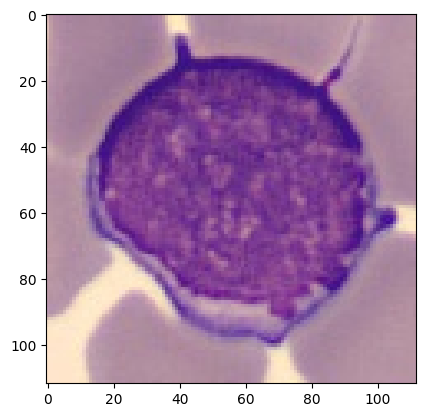

In [10]:
batch = next(iter(validloader))
print('Shape of image tensor:', batch[0].shape)
print('Patient labels:', batch[1].tolist())
plt.imshow(batch[0][0]);

# Model definition

In [11]:
class MILModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.normalize = torchvision.transforms.Normalize(mean=MEAN, std=STD)
        
        self.backbone = timm.create_model('resnet34', pretrained=True, num_classes=0, global_pool='')
        
        self.feature_size = 512
                
        self.max_forward_batch_size = 512
        self.max_backward_batch_size = 512
        
        self.conv = nn.Conv2d(self.feature_size, 1, 1, padding=0)
        self.bn = nn.BatchNorm2d(1, momentum=0.95, affine=True)
        
    def forward(self, images, indices_a=None, indices_b=None, output_features=False):
        num_images = len(images)
                
        if images.dtype == torch.uint8:
            images = self.normalize(images.permute(0, 3, 1, 2).type(torch.float32)/255)
        
        if indices_a is None or indices_b is None:
            assert indices_a is None and indices_b is None
            indices_a = torch.zeros(num_images, dtype=torch.long, device=images.device)
            indices_b = torch.arange(num_images, dtype=torch.long, device=images.device)
        
        features = []
        i = 0
        with torch.no_grad():
            while i < num_images-self.max_backward_batch_size:
                j = min(i+self.max_forward_batch_size, num_images-self.max_backward_batch_size)
                features.append(self.backbone(images[i:j]))
                i = j
        if i < num_images: # does not happen when self.max_backward_batch_size == 0
            features.append(self.backbone(images[i:]))
        features = torch.cat(features, 0)
        
        l = self.conv(features) # these are the logits
        f = torch.sigmoid(self.bn(l.detach())) # weighting factors (alpha)
        
        # The next couple of lines use advanced indexing to re-arrange all the features into each patient.
        num_bags = indices_a.max() + 1
        max_len = indices_b.max() + 1
        x = torch.zeros(num_bags, max_len, *features.shape[1:], device=features.device)
        logits = torch.zeros(num_bags, max_len, *l.shape[1:], device=features.device)
        factors = torch.zeros(num_bags, max_len, *f.shape[1:], device=features.device)
        mask = torch.zeros(num_bags, max_len, device=features.device, dtype=torch.long)
        x[indices_a, indices_b] = features
        factors[indices_a, indices_b] = f
        mask[indices_a, indices_b] = 1
        logits[indices_a, indices_b] = l
                        
        if output_features:
            return logits, mask, factors
        
        # Aggregation
        mask = mask.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        patient_logits = (logits*mask*factors).sum((1, 3, 4))/(mask*factors).sum((1, 3, 4))        

        return patient_logits
            
model = MILModel().to(device)
images, labels, indices_a, indices_b = batch
with torch.no_grad():
    model.eval()
    model(images.to(device), indices_a.to(device), indices_b.to(device))
    
params = model.parameters()
model.optimizer = torch.optim.Adam(params, 1e-3)

In [12]:
# Defines a training step. Used by the helper functions defined at the end of this notebook.
def training_step_fn(model, batch, training=True):
    images, labels, indices_a, indices_b = batch
    labels = labels.to(device)
    
    outputs = model(images.to(device), indices_a.to(device), indices_b.to(device))
    #print(outputs)
    #print(outputs.shape)
    outputs = outputs[..., 0]
    #print('------')
    #print(outputs)
    #print(outputs.shape)
    loss = F.binary_cross_entropy_with_logits(outputs, labels.float(), reduction='none')
    summed_loss = loss.sum() 
    
    probs = outputs.sigmoid()
                    
    predicted = (probs > 0.5).long()
    num_correct_samples = (predicted == labels).float().sum()
    
    return len(labels), num_correct_samples, summed_loss, probs

In [13]:
def on_epoch_end(d): # Save model if balanced accuracy increased
        
    save = False
    
    if not hasattr(model, 'best_valid_accuracy'):
        model.best_valid_accuracy = 0
    if not hasattr(model, 'best_valid_loss'):
        model.best_valid_loss = float('inf')
    if not hasattr(model, 'best_valid_balanced_accuracy'):
        model.best_valid_balanced_accuracy = 0
    
    if d['valid_balanced_accuracy'] > model.best_valid_balanced_accuracy:
        model.best_valid_balanced_accuracy = d['valid_balanced_accuracy']
        model.best_valid_accuracy = d['valid_accuracy']
        model.best_valid_loss = d['valid_loss']
        save = True
    
    if save:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model.optimizer.state_dict()},
        f'{d["valid_balanced_accuracy"]:.4f}.pth')

        print(f'Saved {d["valid_balanced_accuracy"]:.4f}.pth \n')

In [ ]:
# Delete checkpoints from previous training

dir_name = './'
dirs = os.listdir(dir_name)

for item in dirs:
    if item.endswith('.pth'):
        os.remove(os.path.join(dir_name, item))
        print('Removed', os.path.join(dir_name, item))

In [ ]:
# Run the last cell of this notebook first
training_history = train_model(model, training_step_fn, trainloader, validloader, epochs=40, print_every=5, on_epoch_end=on_epoch_end)

Epoch 1, iteration 5/10: running loss 0.6724, running acc 0.6264, batch loss: 0.6012, batch acc: 0.7500, running time per batch: 2.0078s (model) 0.5513s (loader)
Epoch 1, iteration 10/10: running loss 0.6387, running acc 0.6455, batch loss: 0.4733, batch acc: 0.7500, running time per batch: 1.9713s (model) 0.3288s (loader)
Epoch 1: training loss 0.6291, training accuracy 0.6500
Validation accuracy 0.7317, loss 0.4934, balanced accuracy 0.5000

Saved 0.5000.pth 

Epoch 2, iteration 5/10: running loss 0.5828, running acc 0.6082, batch loss: 0.5170, batch acc: 0.7500, running time per batch: 1.7936s (model) 0.4963s (loader)
Epoch 2, iteration 10/10: running loss 0.5250, running acc 0.6946, batch loss: 0.5405, batch acc: 0.6250, running time per batch: 1.8795s (model) 0.2962s (loader)
Epoch 2: training loss 0.5405, training accuracy 0.7000
Validation accuracy 0.7439, loss 0.4535, balanced accuracy 0.5371

Saved 0.5371.pth 

Epoch 3, iteration 5/10: running loss 0.4066, running acc 0.8737, 

# Load best checkpoint and make submission file

In [ ]:
dir_name = './'
dirs = os.listdir(dir_name)

best_bal_acc = 0
best = ''

for item in dirs:
    if item.endswith('.pth'):
        bal_acc = float(item[:6])
        if bal_acc >= best_bal_acc:
            best = str(item)
            best_bal_acc = bal_acc

print('Loading best checkpoint:', best)
checkpoint = torch.load(best)
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
model.eval()

all_probs = []

with torch.no_grad():
    for i, batch in enumerate(tqdm(testloader, position=0, leave=True, disable=True)):
        num_samples, num_correct_samples, summed_loss, logits = training_step_fn(model, batch, training=False)
        all_probs.append(logits.cpu())

all_probs = torch.cat(all_probs, 0)
all_preds = all_probs > 0.5
print('Test set predictions:', all_preds.int().tolist())

In [ ]:
with open('submission.csv', 'w') as f:
    f.write('ID,Predicted\n')
    for ID, pred in zip(test_ids, all_preds):
        f.write(f'{ID},{pred.int().item()}\n')

# Helper functions

In [14]:
def evaluate_model(model, loader, training_step_fn):
    
    total_loss = 0.0
    total_correct = 0.0
    total_samples = 0
    
    all_probs = []
    all_labels = []
        
    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader, position=0, leave=True, disable=True)):
            num_samples, num_correct_samples, summed_loss, probs = training_step_fn(model, batch, training=False)
            
            total_loss += float(summed_loss)
            total_correct += float(num_correct_samples)
            total_samples += float(num_samples)
            
            images, labels, indices_a, indices_b = batch
            all_labels.append(labels)
            all_probs.append(probs.cpu())
            
    all_probs = torch.cat(all_probs, 0)
    all_labels = torch.cat(all_labels, 0)
    bal_acc = bas(all_labels, all_probs > 0.5)
                        
    return total_loss/total_samples, total_correct/total_samples, bal_acc

def train_model(model,
    training_step_fn,
    trainloader,
    validloader=None,
    epochs=2,
    optimizer=None,
    print_every=1,
    on_epoch_end=None,
    save_best_to=False,
    eval_every=None,
    clip_grad_norm=None,
    scheduler=None
    ):
    
    alpha = 0.9

    if optimizer is None:
        assert hasattr(model, 'optimizer'), 'Please provide an optimizer either as argument or by setting model.optimizer = ...'
        optimizer = model.optimizer
        
    total_steps = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_balanced_accuracies = []
    model_times = []

    for epoch in range(epochs):

        running_loss = 0.0
        running_accuracy = 0.0
        running_batch_time = 0.0
        running_loader_time = 0.0
        epoch_loss = 0.0
        epoch_correct = 0.0
        epoch_samples = 0
        
        model.train()
        
        t0 = time.time()
        for i, batch in enumerate(trainloader):
            
            #print(batch[0].shape,batch[1].shape)
            
            if eval_every is not None and (total_steps+1)%eval_every == 0:
                model.eval()
                valid_loss, valid_accuracy, bal_acc = evaluate_model(model, validloader, training_step_fn)
                model.train()
                print(f'Validation accuracy {valid_accuracy:.4f}, loss {valid_loss:.4f}, balanced accuracy {bal_acc:.4f}\n')
                val_losses.append(valid_loss)
                val_accuracies.append(valid_accuracy)
                val_balanced_accuracies.append(bal_acc)
            
            if i == 0:
                running_loader_time = time.time() - t0
            else:
                running_loader_time = running_loader_time * alpha + (1-alpha) * (time.time() - t0)
            
            t0 = time.time()
            
            optimizer.zero_grad()
            
            num_samples, num_correct_samples, summed_loss, logits = training_step_fn(model, batch)
            
            mean_loss = summed_loss/num_samples
            mean_loss.backward()
            if clip_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
            optimizer.step()
            
            model_times.append(time.time() - t0)
            
            epoch_loss += summed_loss.item()
            epoch_correct += num_correct_samples.item()
            epoch_samples += num_samples
            
            accuracy = num_correct_samples/num_samples

            train_losses.append(mean_loss.item())
            train_accuracies.append(accuracy.item())

            if i == 0:
                running_loss = mean_loss.item()
                running_accuracy = accuracy.item()
                running_batch_time = time.time() - t0
            else:
                running_loss = running_loss * alpha + (1-alpha) * mean_loss.item()
                running_accuracy = running_accuracy * alpha + (1-alpha) * accuracy.item()
                running_batch_time = running_batch_time * alpha + (1-alpha) * (time.time() - t0)
                
            if i%print_every == print_every-1:
                print(f'Epoch {epoch+1}, iteration {i+1}/{len(trainloader)}: running loss {running_loss:.4f}, running acc {running_accuracy:.4f}, batch loss: {mean_loss.item():.4f}, batch acc: {accuracy.item():.4f}, running time per batch: {running_batch_time:.4f}s (model) {running_loader_time:.4f}s (loader)')
            
            if scheduler is not None:
                scheduler.step()
            
            t0 = time.time()
            
            total_steps += 1
        
        train_loss = epoch_loss/epoch_samples
        train_accuracy = epoch_correct/epoch_samples
        print(f'Epoch {epoch+1}: training loss {train_loss:.4f}, training accuracy {train_accuracy:.4f}')
        
        if validloader is not None and eval_every is None:
            model.eval()
            valid_loss, valid_accuracy, bal_acc = evaluate_model(model, validloader, training_step_fn)
            model.train()
            print(f'Validation accuracy {valid_accuracy:.4f}, loss {valid_loss:.4f}, balanced accuracy {bal_acc:.4f}\n')
            val_losses.append(valid_loss)
            val_accuracies.append(valid_accuracy)
            val_balanced_accuracies.append(bal_acc)
        
        if on_epoch_end is not None:
            on_epoch_end({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'valid_loss': None if validloader is None else valid_loss,
                'valid_accuracy': None if validloader is None else valid_accuracy,
                'valid_balanced_accuracy': None if validloader is None else bal_acc,
            })

    print('Finished Training')

    return train_losses, train_accuracies, val_losses, val_accuracies, val_balanced_accuracies, model_times